# Project B: Spam/Ham Classification

The purpose of this project is to create a binary classifier that can distinguish spam (junk, commercial, or bulk) emails from ham (regular non-spam) emails.

This first part of the project focuses on initial analysis, feature engineering, and logistic regression. In the second part of this project, I will build my own spam/ham classifier.

This is a **real-world** dataset —— the emails you are trying to classify are actual spam and legitimate emails. As a result, some of the spam emails may be in poor taste or be considered inappropriate. We think the benefit of working with realistic data outweighs these inappropriate emails but wanted to provide a warning at the beginning of the project so that you are aware.

In [1]:
# Run this cell to suppress all FutureWarnings.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# More readable exceptions.
%pip install --quiet iwut
%load_ext iwut
%wut on


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [21]:
import numpy as np
import pandas as pd
import sys

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

from datetime import datetime
from IPython.display import display, HTML

# The Data

In email classification, our goal is to classify emails as spam or not spam (referred to as "ham") using features generated from the text in the email. The dataset is from [SpamAssassin](https://spamassassin.apache.org/old/publiccorpus/). It consists of email messages and their labels (0 for ham, 1 for spam). The labeled training dataset contains 8,348 labeled examples, and the unlabeled test set contains 1,000 unlabeled examples.

**Note:** The dataset is from 2004, so the contents of emails might be very different from those in 2024.

Run the following cells to load the data into a `DataFrame`.

The `train` `DataFrame` contains labeled data we will use to train the model. It has four columns:

1. `id`: An identifier for the training example.
1. `subject`: The subject of the email.
1. `email`: The text of the email.
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam).

The `test` `DataFrame` contains 1,000 unlabeled emails. Later, we will predict labels for these emails.

In [3]:
import zipfile

# Loading training and test datasets
with zipfile.ZipFile('spam_ham_data.zip') as item:
    with item.open("train.csv") as f:
        original_training_data = pd.read_csv(f)
    with item.open("test.csv") as f:
        test = pd.read_csv(f)

In [4]:
# Convert the emails to lowercase as the first step of text processing.
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


First, let's check if our data contains any missing values. We have filled in the cell below to print the number of `NaN` values in each column. If there are `NaN` values, we replace them with appropriate filler values (i.e., `NaN` values in the `subject` or `email` columns will be replaced with empty strings). Finally, we print the number of `NaN` values in each column after this modification to verify that there are no `NaN` values left.

**Note:** While there are no `NaN` values in the `spam` column, we should be careful when replacing `NaN` labels. Doing so without consideration may introduce significant bias into our model.

In [6]:
print('Before imputation:')
print(original_training_data.isnull().sum())
original_training_data = original_training_data.fillna('')
print('------------')
print('After imputation:')
print(original_training_data.isnull().sum())

Before imputation:
id         0
subject    6
email      0
spam       0
dtype: int64
------------
After imputation:
id         0
subject    0
email      0
spam       0
dtype: int64


# Part 1: Initial Analysis

In the cell below, we have printed the text of the `email` field for the first ham and the first spam email in the original training set.

In [7]:
first_ham = original_training_data.loc[original_training_data['spam'] == 0, 'email'].iloc[0]
first_spam = original_training_data.loc[original_training_data['spam'] == 1, 'email'].iloc[0]
print("Ham Email:")
print(first_ham)
print("-------------------------------------------------")
print("Spam Email:")
print(first_spam)

Ham Email:
url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

-------------------------------------------------
Spam Email:
<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



## Training-Validation Split
The training data we downloaded is all the data we have available for both training models and **validating** the models that we train. We, therefore, need to split the training data into separate training and validation datasets. We will need this **validation data** to assess the performance of the classifier once we are finished training.

In [9]:
# This creates a 90/10 train-validation split on our labeled data.
from sklearn.model_selection import train_test_split

train, val = train_test_split(original_training_data, test_size=0.1, random_state=42)

# Part 2: Feature Engineering

We want to take the text of an email and predict whether the email is ham or spam. This is a **binary classification** problem, so we can use logistic regression to train a classifier. Recall that to train a logistic regression model, we need a numeric feature matrix $\mathbb{X}$ and a vector of corresponding binary labels $Y$. Unfortunately, our data are text, not numbers. To address this, we can create numeric features derived from the email text and use those features for logistic regression.

Each row of $\mathbb{X}$ is an email. Each column of $\mathbb{X}$ contains one feature for all the emails. We'll guide you through creating a simple feature, and you'll create more interesting ones as you try to increase the accuracy of your model.

Create a function `words_in_texts` that takes in a list of interesting words (`words`) and a `Series` of emails (`texts`). Our goal is to check if each word in `words` is contained in the emails in `texts`.

The `words_in_texts` function should output a **2-dimensional `NumPy` array** that contains one row for each email in `texts` and one column for each word in `words`. If the $j$-th word in `words` is present at least once in the $i$-th email in `texts`, the output array should have a value of 1 at the position $(i, j)$. Otherwise, if the $j$-th word is not present in the $i$-th email, the value at $(i, j)$ should be 0.

In [10]:
def words_in_texts(words, texts):
    """
    Args:
        words (list): Words to find.
        texts (Series): Strings to search in.
    
    Returns:
        A 2D NumPy array of 0s and 1s with shape (n, d) where 
        n is the number of texts, and d is the number of words.
    """
    df = pd.DataFrame({word: texts.str.contains(word).astype(int) for word in words})
    return df.values

In [11]:
# Run this cell to see what your function outputs. Compare the results to the example provided above.
words_in_texts(['hello', 'bye', 'world'], pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])

# Part 3: EDA

We need to identify some features that allow us to distinguish spam emails from ham emails. One idea is to compare the distribution of a single feature in spam emails to the distribution of the same feature in ham emails. Suppose the feature is a binary indicator, such as whether a particular word occurs in the text. In that case, this compares the proportion of spam emails with the word to the proportion of ham emails with the word.

The following plot (created using `sns.barplot`) compares the proportion of emails in each class containing a particular set of words. The bars colored by email class were generated by setting the `hue` parameter of `sns.barplot` to a column containing the class (spam or ham) of each data point. An example of how this class column was created is shown below:

![training conditional proportions](images/training_conditional_proportions.png)

You can use `DataFrame`'s `.melt` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.melt.html)) method to "unpivot" a `DataFrame`. See the following code cell for an example.

In [13]:
from IPython.display import display, Markdown
df = pd.DataFrame({
    'word_1': [1, 0, 1, 0],
    'word_2': [0, 1, 0, 1],
    'type': ['spam', 'ham', 'ham', 'ham']
})
display(Markdown("> Our original `DataFrame` has a `type` column and some columns corresponding to words. You can think of each row as a sentence, and the value of 1 or 0 indicates the number of occurrences of the word in this sentence."))
display(df);
display(Markdown("> `melt` will turn columns into entries in a variable column. Notice how `word_1` and `word_2` become entries in `variable`; their values are stored in the `value` column."))
display(df.melt("type"))

> Our original `DataFrame` has a `type` column and some columns corresponding to words. You can think of each row as a sentence, and the value of 1 or 0 indicates the number of occurrences of the word in this sentence.

,word_1,word_2,type
0,1,0,spam
1,0,1,ham
2,1,0,ham
3,0,1,ham


> `melt` will turn columns into entries in a variable column. Notice how `word_1` and `word_2` become entries in `variable`; their values are stored in the `value` column.

,type,variable,value
0,spam,word_1,1
1,ham,word_1,0
2,ham,word_1,1
3,ham,word_1,0
4,spam,word_2,0
5,ham,word_2,1
6,ham,word_2,0
7,ham,word_2,1


Create the bar chart above by comparing the proportion of spam and ham emails containing specific words. **Choose a set of 6 words other than those shown in the example.** These words should have different proportions for the two classes (i.e., noticeably different bar heights across spam and ham). Make sure only to consider emails from `train`. Your `words_in_texts` function from the previous part will be useful here. 

Next, see how to make this plot with `sns.barplot`. Take a look at the [documentation](https://seaborn.pydata.org/generated/seaborn.barplot.html) and determine what the inputs should be. A possible data input is given below:
<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>type</th>      <th>variable</th>      <th>value</th>    </tr>  </thead>  <tbody>    
<tr>      <th>0</th>      <td>Ham</td>      <td>word_1</td>      <td>0.021269</td>    </tr>    
<tr>      <th>1</th>      <td>Ham</td>      <td>word_2</td>      <td>0.101519</td>    </tr>    
<tr>      <th>2</th>      <td>Spam</td>      <td>word_3</td>      <td>0.059160</td>    </tr>    
<tr>      <th>3</th>      <td>Spam</td>      <td>word_2</td>      <td>0.017694</td>    </tr>    
<tr>      <th>4</th>      <td>Ham</td>      <td>word_4</td>      <td>0.013226</td>    </tr>     
<tr>      <th>...</th>      <td>...</td>      <td>...</td>      <td>...</td>    </tr>    
</tbody></table>

Finally, you will need to chain some `pandas` functions together. Try to add one function at a time and see how that affects the `DataFrame`. It may help to use a new cell or print out the `DataFrame` for debugging purposes as you work towards achieving the desired format above.

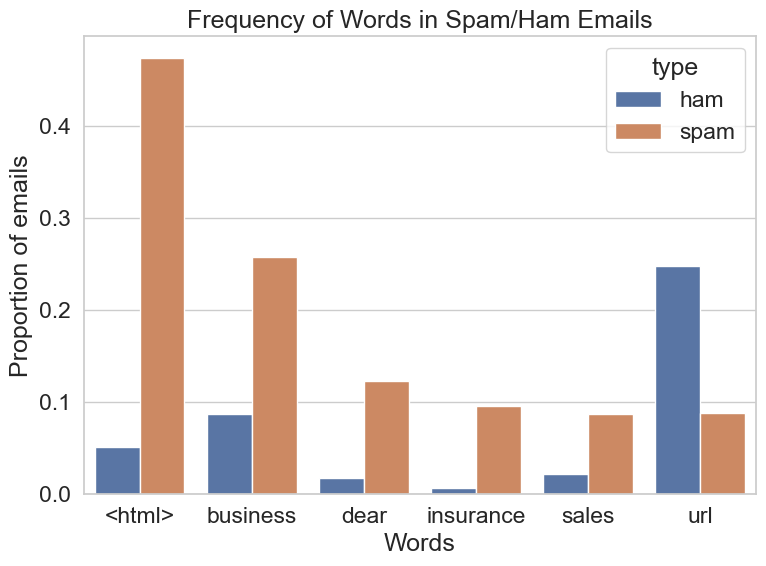

In [14]:
train = train.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_in_texts.
plt.figure(figsize=(8,6))
words = ["<html>", "insurance", "business", "sales", "url", "dear"]

X = words_in_texts(words, train["email"])
df = pd.DataFrame(X, columns=words)
df["type"] = train["spam"].map({1: "spam", 0: "ham"})
melted = df.melt("type")

mean = melted.groupby(["type", "variable"])["value"].mean()
prop = mean.reset_index(name="proportion of emails").rename(columns={"variable": "word"})

sns.barplot(x="word", y="proportion of emails", hue="type", data=prop)

plt.xlabel('Words')
plt.ylabel('Proportion of emails')
plt.title('Frequency of Words in Spam/Ham Emails')
plt.tight_layout()
plt.show()

When the feature is binary, it makes sense to compare its proportions across classes (as in the previous question). Otherwise, if the feature can take on numeric values, we can compare the distributions of these values for different classes.

# Part 4: Basic Classification

Notice that the output of `words_in_texts(words, train['email'])` is a numeric matrix containing features for each email. This means we can use it directly to train a classifier!

We've given you 5 words that might be useful as features to distinguish spam/ham emails. Use these words and the `train` `DataFrame` to create two `NumPy` arrays: `X_train` and `Y_train`. `X_train` should be a 2D array of 0s and 1s created using your `words_in_texts` function on all the emails in the training set. `Y_train` should be a vector of the correct labels for each email in the training set.


In [15]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train["email"])
Y_train = train["spam"].to_numpy()

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]),
 array([0, 0, 0, 0, 0]))

Now that we have matrices, we can build a model with `sklearn`! Using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier, train a logistic regression model using `X_train` and `Y_train`. Then, output the model's training accuracy below. You should get an accuracy of around $0.76$.

In [16]:
from sklearn.linear_model import LogisticRegression

my_model = LogisticRegression()
my_model.fit(X_train, Y_train)

training_accuracy = my_model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7576201251164648


In [17]:
assert np.allclose(my_model.coef_, np.array([[ 0.3876794 ,  1.41303343,  2.04437707, -0.53676679,  0.92334944]]))

That doesn't seem too shabby! But the classifier you made above isn't as good as the accuracy would make you believe. First, we are evaluating the accuracy of the model on the training set, which may be a misleading measure. Accuracy on the training set doesn't always translate to accuracy in the real world (on the test set). In future parts of this analysis, we will make use of the data we held out for model validation and comparison.

Presumably, our classifier will be used for **filtering**, or preventing messages labeled `spam` from reaching someone's inbox. There are two kinds of errors we can make:
- **False positive (FP)**: A ham email gets flagged as spam and filtered out of the inbox.
- **False negative (FN)**: A spam email gets mislabeled as ham and ends up in the inbox.

To be clear, we label spam emails as 1 and ham emails as 0. These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier in addition to overall accuracy:

**Precision**: Measures the proportion of emails flagged as spam that are actually spam. Mathematically, $\frac{\text{TP}}{\text{TP} + \text{FP}}$.

**Recall**: Measures the proportion  of spam emails that were correctly flagged as spam. Mathematically, $\frac{\text{TP}}{\text{TP} + \text{FN}}$.

**False positive rate**: Measures the proportion  of ham emails that were incorrectly flagged as spam. Mathematically, $\frac{\text{FP}}{\text{FP} + \text{TN}}$.

One quick mnemonic to remember the formulas is that **P**recision involves T**P** and F**P**, Recall does not. In the final, the reference sheet will also contain the formulas shown above, but you should be able to interpret what they mean and their importance depending on the context.

The below graphic (modified slightly from [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)) may help you understand precision and recall visually:<br />
<center>
<img alt="precision_recall" src="images/precision_recall.png" width="600px" />
</center>

Note that a True Positive (TP) is a spam email that is classified as spam, and a True Negative (TN) is a ham email that is classified as ham.

Suppose we have a hypothetical classifier called the “zero predictor.” For any inputted email, the zero predictor *always* predicts 0 (it never makes a prediction of 1 for any email). How many false positives and false negatives would this classifier have if it were evaluated on the training set and its results were compared to `Y_train`? Assign `zero_predictor_fp` to the number of false positives and `zero_predictor_fn` to the number of false negatives for the hypothetical zero predictor on the training data.


In [18]:
zero_predictor_fp = 0
zero_predictor_fn = Y_train.sum()
zero_predictor_fp, zero_predictor_fn

(0, 1918)

What is the accuracy and recall of the zero predictor on the training data? Do not use any `sklearn` functions to compute these performance metrics.

In [19]:
# acc = (tp + tn) / total
zero_predictor_acc = (0 + len(Y_train) - zero_predictor_fn) / len(Y_train)
zero_predictor_recall = 0 / (0 + zero_predictor_fn)
zero_predictor_acc, zero_predictor_recall

(0.7447091707706642, 0.0)

zero_predictor_fp is 0 as the classifier never predicts 1, thus it can never be the case of false positive. 
zero_predictor_fn is the sum of all Y_train as every spam message is predicted 0, and thus the classifier misses all of them. 
zero_predictor_acc is the proportion of all the model's prediction that are correct. Thus the formula is (tp + tn) / total. tp is 0 as the model never predicts 1, tn is every actual 0 that is correctly predicted 0, thus is total - sum of Y_train.
zero_predictor_recall, by definition is tp / (tp + fn). As mentioned earlier, we just plug in the numbers. 

Compute the precision, recall, and false positive rate of the `LogisticRegression` classifier `my_model`. Do **not** use any `sklearn` functions to compute performance metrics; the only `sklearn` method you may use here is `.predict` to generate model predictions using `my_model` and `X_train`.

In [20]:
Y_train_hat = my_model.predict(X_train)

TP = ((Y_train_hat == 1) & (Y_train == 1)).sum()
TN = ((Y_train_hat == 0) & (Y_train == 0)).sum()
FP = ((Y_train_hat == 1) & (Y_train == 0)).sum()
FN = ((Y_train_hat == 0) & (Y_train == 1)).sum()
logistic_predictor_precision = TP / (TP + FP)
logistic_predictor_recall = TP / (TP + FN)
logistic_predictor_fpr = FP / (FP + TN)

print(f"{TP=}, {TN=}, {FP=}, {FN=}")
print(f"{logistic_predictor_precision=:.2f}, {logistic_predictor_recall=:.2f}, {logistic_predictor_fpr=:.2f}")

TP=219, TN=5473, FP=122, FN=1699
logistic_predictor_precision=0.64, logistic_predictor_recall=0.11, logistic_predictor_fpr=0.02


The accuracy for my_model slightly improved from aprox 0.745 to 0.758

One reason my_model is performing poorly may be because we are only using 5 words. Another reason can be that most emails, both spam and ham, do not contain any of these 5 words, thus the model falls back to predicting the majority class asa ham almost all the time. 

In this part, you will build and improve on the concepts and functions you implemented in before to create your own classifier to distinguish spam emails from ham (non-spam) emails. We will evaluate your work based on your model's accuracy and written responses in this notebook.

After this assignment, you should feel comfortable with the following:

- Using `sklearn` libraries to process data and fit classification models.
- Validating the performance of your model and minimizing overfitting.
- Generating and analyzing ROC curves.


In [22]:
import zipfile
with zipfile.ZipFile('spam_ham_data.zip') as item:
    with item.open("train.csv") as f:
        original_training_data = pd.read_csv(f)
    with item.open("test.csv") as f:
        test = pd.read_csv(f)

In [23]:
# Convert the emails to lowercase as the first step of text processing.
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


Feel free to explore the dataset above along with any specific spam and ham emails that interest you. Keep in mind that our data may contain missing values, which are handled in the following cell.

In [25]:
# Fill any missing or NAN values.
print('Before imputation:')
print(original_training_data.isnull().sum())
original_training_data = original_training_data.fillna('')
print('------------')
print('After imputation:')
print(original_training_data.isnull().sum())

Before imputation:
id         0
subject    6
email      0
spam       0
dtype: int64
------------
After imputation:
id         0
subject    0
email      0
spam       0
dtype: int64


## Training/Validation Split

Recall that the training data we downloaded is all the data we have available for both training models and **validating** the models that we train. Therefore, we split the training data into separate training and validation datasets. Once you have finished training, you will need this validation data to assess the performance of your classifier. 

## Feature Engineering

We need a numeric feature matrix $\mathbb{X}$ and a vector of corresponding binary labels $\mathbb{Y}$ to train a logistic regression model. In Project B1, we implemented the function `words_in_texts`, which creates numeric features derived from the email text and uses those features for logistic regression. 

For this project, we have provided you with an implemented version of `words_in_texts`. Remember that the function outputs a 2-dimensional `NumPy` array containing one row for each email text. The row should contain a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does. 

Run the following cell to see how the function works on some text.

In [27]:
from projB2_utils import *

words_in_texts(['hello', 'bye', 'world'], pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])

## EDA and Basic Classification

From above, we visualized the frequency of different words in spam and ham emails and used `words_in_texts(words, train['email'])` to train a classifier directly. We also provided a simple set of 5 words that might be useful as features to distinguish spam/ham emails. 

We then built a model using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier from `sklearn`.

# Moving Forward

With this in mind, it is now your task to make the spam filter more accurate. To determine your accuracy on the test set, you will use your classifier to predict every email in the `test` `DataFrame`.

Here are some ideas for improving your model:

1. Finding better features based on the email text. Some example features are:
    1. Number of characters in the subject/body
    1. Number of words in the subject/body
    1. Use of punctuation (e.g., how many '!'s were there?)
    1. Number/percentage of capital letters 
    1. Whether the email is a reply to an earlier email or a forwarded email
1. Finding better words to use as features. Which words are the best at distinguishing emails? This requires digging into the email text itself. Alternatively, you can identify misclassified emails and see which relevant words are missing in your model.
1. Reducing dimensionality and/or multicollinearity. There are a few methods to achieve this:
    1. Interpret the model coefficients. Note that a feature will be more valuable in classification if its coefficient has a larger **absolute** value. If the coefficient has a lower **absolute** value, the feature likely isn't valuable in classifying emails.
1. Better data processing. For example, many emails contain HTML as well as text. You can consider extracting the text from the HTML to help you find better words. Or, you can match HTML tags themselves, or even some combination of the two.
1. Model selection. You can adjust the parameters of your model (e.g. the penalty type, the regularization parameter, or any arguments in `LogisticRegression`) to achieve higher accuracy. Recall that you should use cross-validation for feature and model selection! Otherwise, you will likely overfit to your training data.
    1. Consider implementing L1 regularization. The [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for `LogisticRegression` may be helpful here. 
    1. We have imported `GridSearchCV` for you. You may use sklearn's `GridSearchCV` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)) class to perform cross-validation. You do not need to code cross-validation from scratch, though you are welcome to do so.

Here's an example of how to use `GridSearchCV`. Suppose we wanted to experiment with 4 different solvers (numerical methods for optimizing the mode) models for a `LogisticRegression` model `lr_model`. 
1. We could define a dictionary specifying the hyperparameters and the specific values we want to try out like so: `parameters = {'solver':[{'lbfgs', 'liblinear', 'newton-cg', 'saga']}`.
2. Running `grid = GridSearchCV(estimator=lr_model, param_grid=parameters)` would give us a model for each combination of hyperparameters we are testing - in this case, just 4 models.
3. We fit each model to some training data `X_train` and `Y_train` using `grid_result = grid.fit(X_train, Y_train)`.
4. Indexing into `grid_result.cv_results_` with a particular metric (in this case, `mean_test_score`), we get an array with the scores corresponding to each of the models. `grid_result.cv_results_['mean_test_score']`.
Feel free to experiment with other hyperparameters and metrics as well. The documentation is your friend!     
       
You may use whatever method you prefer to create features, but **you may only use the packages we've imported for you in the cell below or earlier in this notebook**. In addition, **you are only allowed to train logistic regression models**. No decision trees, random forests, k-nearest-neighbors, neural nets, etc. 

**Note 1:** You may want to use your **validation data** to evaluate your model and get a better sense of how it will perform on the test set. However, you may overfit to your validation set if you try to optimize your validation accuracy too much. Alternatively, you can perform cross-validation on the entire training set.

**Note 2:** If you see a `ConvergenceWarning`, increase the maximum number of iterations the model runs for by passing in a parameter, `max_iter`, into `LogisticRegression()`. This should get rid of the warning. For a longer discussion on why this warning appears, you might find [this StackOverflow post](https://stackoverflow.com/questions/62658215/convergencewarning-lbfgs-failed-to-converge-status-1-stop-total-no-of-iter) helpful. Convergence of solvers is not in scope for Data 100, but by understanding what the error messages are saying, you can get some useful context on what to do in these situations.

To decide which features to use when building your model, it is helpful to conduct EDA. Show a visualization you used to select features for your model. 

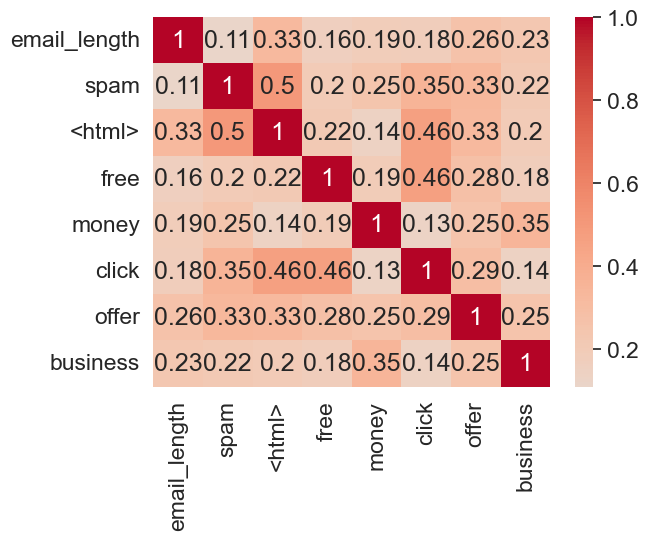

In [30]:
train_copy = train.copy() 
train_copy["email_length"] = train_copy["email"].str.len()

features = ["<html>", "free", "money", "click", "offer", "business"]
X = words_in_texts(features, train_copy["email"])
df_words = pd.DataFrame(X, columns=features)
df_all = pd.concat([train_copy[["email_length", "spam"]], df_words], axis=1)
corr = df_all.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.show()

I plotted the correlation heatmap with pairwise correlations among binary indicator features. "<html>" has by far the strongest linear association with sapm, so emails containing raw HTML tags are much more likely to be spam. Email length alone is weakly correlated with sapm, so it is a poor discriminator. There is some correlation between click and offer, and between money and business. This suggest that thoses pairs could co-occur, but with 0.29 and 0.35, they are not so high so that I hace to drop one of them outright.

Now that you've explored the data and relevant features through EDA, it's time to build your model! As mentioned earlier, you may use whatever method you prefer to create features, but **you may only use the packages we've imported for you in the cell below or earlier in this notebook**. In addition, **you are only allowed to train logistic regression models**. No decision trees, random forests, k-nearest-neighbors, neural nets, etc. 

Please consider the ideas mentioned above when choosing features. We have not provided any code to do this, so feel free to create as many cells as you need to tackle this task. 

In [31]:
# import libraries
# You may use any of these to create your features.
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import re
from collections import Counter

In [32]:
# Define your processing function, processed data, and model here. 
# You may find it helpful to look through the rest of the questions first!

def build_features(df):
    df2 = df.copy()
    df2['email']   = df2['email'].fillna('').astype(str)
    
    features = ["free", "money", "click", "offer", "win"]
    X_words = words_in_texts(features, df2["email"])
    df_words = pd.DataFrame(X_words, columns=features, index=df2.index)

    df_fx = pd.DataFrame(index=df2.index)
    df_fx["email_length"] = df2["email"].str.len()
    df_fx["has_money_number"] = df2["email"].str.contains(r"\$\d+|\d+\s+dollars", case=False).astype(int)
    df_fx["num_exclaims"] = df2["email"].str.count("!")
    df_fx["num_qmark"] = df["email"].str.count(r"\?")
    df_fx["pct_caps"] = df2["email"].apply(lambda x: sum(1 for c in x if c.isupper())/max(len(x),1))
    df_fx["has_html_tag"] = df2["email"].str.contains(r"<html>|<tag>", case=False, regex=True).fillna(False).astype(int)
    return pd.concat([df_fx, df_words], axis=1).fillna(0).values

X_train = build_features(train)
Y_train = train["spam"].values

X_val = build_features(val)
Y_val = val["spam"].values


lr = LogisticRegression(
        fit_intercept=True,
        penalty='l2',
        max_iter=1000)

lr.fit(X_train, Y_train)

LogisticRegression(max_iter=1000)

Assign your predictions for the class of each data point in the training set `train` to `train_predictions`.

In [33]:
train_predictions = lr.predict(X_train)

# Print your training accuracy. 
training_accuracy = np.mean(train_predictions == train["spam"])
training_accuracy

0.8714228670304806

### Cross Validation

In [35]:
# See a 10 fold CV for the simple 5 word model from the intro. Feel free to edit this cell.
compute_CV_error(X_train, train["spam"], folds=10)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

[0.8789893617021277,
 0.8723404255319149,
 0.8670212765957447,
 0.8761651131824234,
 0.8801597869507324,
 0.8215712383488681,
 0.848202396804261,
 0.8668442077230359,
 0.8428761651131824,
 0.8908122503328895]

The following code will write your predictions on the test dataset to a CSV file. Assign your predictions for the class of each datapoint in the test set `test` to a 1-dimensional array called `test_predictions`. 

In [36]:
test_predictions = lr.predict(build_features(test))

The following cell generates a CSV file with your predictions. **You must submit this CSV file to the "Project B2 Test Set Predictions" assignment on Gradescope to get credit for this question.** You can only submit to Gradescope a maximum of 4 times per day, so please use your submissions wisely!

In [37]:
# Assuming that your predictions on the test set are stored in a 1-dimensional array called
# test_predictions. Feel free to modify this cell as long you create a CSV in the right format.

# Construct and save the submission:
submission_df = pd.DataFrame({
    "Id": test['id'], 
    "Class": test_predictions,
}, columns=['Id', 'Class'])
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = "submission_{}.csv".format(timestamp)
submission_df.to_csv(filename, index=False)

print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
display(HTML("Download your test prediction <a href='" + filename + "' download>here</a>."))
print('You may now upload this CSV file to Gradescope for scoring.')#

Created a CSV file: submission_20260106_225603.csv.


You may now upload this CSV file to Gradescope for scoring.


# Analyzing Your Model

Describe the process of improving your model. You should use at least 2-3 sentences each to address the following questions:

1. How did you find better features for your model?
2. What did you try that worked or didn't work?
3. What was surprising in your search for good features?

1. Some good feature that I found were based on the frequencies on the word in spam and ham emails. Also, I notes recurring patterns like excessive punctuation and the use of CAPITAL LETTERS in spam emails. 

2. I tried first to just use "http" as a word but found that it was better to determine the existence of <html> and <tag>. Also, I feel like email length don't have a strong correlation, but I decided to include it anyways. Something that worked is the coutning of http, when I read the email content for spam emails, they appear multiple times. 

3. I found that 1-3 excalims signs were a good identifier for spam emails, but beyond that, the classifier did not render well. Also, some words were highly related to spam emails, like lottery, but their frequency were low when counting the whole set of spam emails. 

# ROC Curve

In most cases, we won't be able to get 0 false positives and 0 false negatives, so we have to compromise. For example, in the case of cancer screenings, false negatives are comparatively worse than false positives — a false negative means that a patient might not discover that they have cancer until it's too late. In contrast, a patient can receive another screening for a false positive.

Recall that logistic regression calculates the probability that an example belongs to a particular class. To classify an example, we say that an email is spam if our classifier gives it $\ge 0.5$ probability of being spam. However, **we can adjust that cutoff threshold**. We can say that an email is spam only if our classifier gives it $\ge 0.7$ probability of being spam, for example. This is how we can trade off false positives and false negatives.

The Receiver Operating Characteristic (ROC) curve shows this trade-off for each possible cutoff probability. In the cell below, plot an ROC curve for your final classifier (the one you use to make predictions for Gradescope) on the training data.


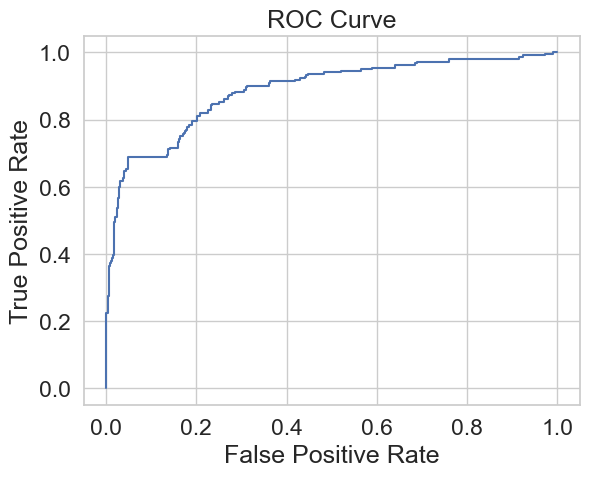

In [39]:
Y_scores = lr.predict_proba(X_val)[:,1]

fpr, tpr, thresholds = roc_curve(Y_val, Y_scores)

metrics = pd.DataFrame({
    "FPR": fpr,
    "TPR": tpr,
    "Threshold": thresholds
})
plt.plot(fpr, tpr, label="ROC Curve")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

# fig = plt.plot(metrics, x="FPR", y="TPR", title="ROC Curve", 
#        width=600, height=600, render_mode="svg")

plt.show()

To help you better understand some of the challenges that arise with classification, we've selected three emails from the `train` `DataFrame` and provided them below. Each email highlights a different issue that could arise. Skim through each of the emails below before answering part a).

In [40]:
# Just run this cell, don't modify it.

print("spam: " + str(train.loc[5216]["spam"]))
print("\nemail:\n" + train.loc[5216]["email"])

spam: 1

email:
hello you two,
 
 i am so sorry catherine for not writing recently. i have just been vv busybeing a working mother and sometimes it all gets too much you know!! i cannot wait to see you both although we may meet at the airport on the 16/6 as that's the day we're going to france but i will see you both at bronagh's house for her 30th which we're going to on the way back from the airport. i am so excited about seeing you!!! liitle eva ( aine) was born on tuesday
  she is absolutely incredible. poor bronagh is 11 dsays over!!
 sounds like you've been having an amazing time. hope you won't be too depressed to be back!!
 
 lots of love
 
 deirdre
 "justin mason" <jm@jmason.org> wrote:
 
 <  
 <  just a quick note -
 <  
 <  we've decided to go up to annapurna base camp instead of
 <  the jomsom trek - it's a bit more impressive visually
 <  (if a little soggier).   so as of tomorrow morning, ourselves
 <  and our guide bhadra will be leaping like gazelles up 4000-odd
 <  met

In [41]:
# Just run this cell, don't modify it.

print("spam: " + str(train.loc[36]["spam"]))
print("\nemail:\n" + train.loc[36]["email"])

spam: 0

email:
lifetime movie newsletter
 
 this week's movies to watch on lifetime
 
 [ http://www.lifetimetv.com/movies/index.html ]
 
 august 19, 2002
 
 *************************************************************************
 
 coming at you this week...
 
 1) "the secret life of zoey" premiere!
 2) the buzz about the upcoming movie
 3) movies airing this week
 4) big event: a martinez sunday
 5) fun and games
 
 *************************************************************************
 
 "the secret life of zoey" premiere!
 
 take a sneak peek at lifetimes next exciting original movie, "the secret life of zoey" [ http://www.lifetimetv.com/movies/info/move3195.html ], airing on monday, august 19 at 9 pm et/pt. zoey's mom thought she knew everything about her perfect teenage daughter. but when she realizes that her child is addicted to drugs, both of their worlds spin out of control. this dramatic film delves into the topic of teenage drug addiction and features stellar performer

In [42]:
# Just run this cell, don't modify it.

print("spam: " + str(train.loc[1092]["spam"]))
print("\nemail:\n" + train.loc[1092]["email"])

spam: 0

email:
this is a multi part message in mime format.
 
 --_nextpart_1_bvfoditvghtocxfdvjnkcuwblfv
 content-type: text/plain; charset="us-ascii"
 content-transfer-encoding: 7bit
 
 ........... with our telecoms partner bumblebee !
 
 don't get ripped off by expensive hotel, payphone and mobile charges. 
 save, save, save on international calls with ryanair's phone partner. 
 ************************************************************************
 *********
 
 you'll save up to 70% on international phone calls when you use our 
 online phone card.  you can use the card from any phone in any country 
 you visit and you won't have to worry about high phone charges 
 when you call home or the office.
 
 buying a card couldn't be easier and it's totally secure.  simply go to
 http://www.bumblebeecommunications.com/lowcostcalls/  
  to avail of this special offer for ryanair customers.
 
 it's another great deal from ryanair and our online phone 
 partner, bumblebee communications. 


Pick at least **one** of the emails provided above to comment on. How would you classify the email (e.g., spam or ham), and does this align with the classification provided in the training data? What could be a reason someone would disagree with *your* classification of the email? In 2-3 sentences, explain your perspective and potential reasons for disagreement.

I would classify example 3 as spam, it contains promotional links, pricing pitches, and special offers, also, the last paragraph mentions being subscribed to this. But this disagrees with the classification, as it classifies that as 0. A reason someone would disagree with my classification is that it included disclaimers and comes from a known partner address. 

As data scientists, we sometimes take the data to be a fixed “ground truth,” establishing the “correct” classification of emails. However, as you might have seen above, some emails can be ambiguous; people may disagree about whether an email is actually spam or ham. How does the ambiguity in our labeled data (spam or ham) affect our understanding of the model's predictions and the way we measure/evaluate our model's performance?

Ambiguous label means that there is a limit to which an classifier can perform, thus there could not exist a perfect model as there will be cases where human disagree. As a result, raw accuracy, precision, reacall can be misleading (some of the false positives or negatives may be ambiguous)

Now, let's start thinking about your model's interpretability and what that means more broadly for an email classification task. A model is considered interpretable if humans can easily understand the reasoning behind its predictions and classifications. First, let's see if we can understand how our choice of features relates to how a particular email is classified. 

#### Part i

Let’s take a look at the `simple_model` we provided you earlier that uses 5 features. We have provided the code below for ease of reference. You will examine how a particular feature influences how an email is classified. 

In [43]:
# Simple model introduced at the start of this notebook. Just pay attention to the features.
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train['email'])
Y_train = np.array(train['spam'])

simple_model = LogisticRegression()
simple_model.fit(X_train, Y_train);

Pick an email from the training set and assign its index to `email_idx`. Then, find **one** feature used in `simple_model` such that **removing** it changes how that email is classified. Assign this feature to  `feature_to_remove`.

**Hint**: We suggest starting with finding spam emails that contain the features in our model. All the features in our simple model relate to spam emails, thus it is easier to find a spam email + remove a feature to get it to flip classes.

In [45]:
# Use this cell for scratch work when determining `email_idx`
email_idx = None
feature_to_remove = None

for idx in train[train["spam"] == 1].index:
    feature = X_train[idx]
    for i, word in enumerate(some_words):
        if feature[i] > 0:
            modified = feature.copy()
            modified[i] = 0
            pred = simple_model.predict(modified.reshape(1, -1))[0]
            if pred == 0:
                email_idx = idx
                feature_to_remove = word
                break
    if email_idx is not None:
        break

print(email_idx, feature_to_remove)

27 bank


In [46]:
email_idx = 27

prob_spam = simple_model.predict_proba(X_train)[:, 1]
initial_prob = prob_spam[email_idx]
initial_class = "spam" if np.round(initial_prob) else "ham"
print(f"\nPredicted probability of being spam: {np.round(initial_prob*100, 2)}%")
print("\nEmail:\n" + train.loc[email_idx]["email"])


Predicted probability of being spam: 55.57%

Email:
dear opportunities seekers:
 
 i thought you just might be interested in the followings:
 
 we are currently hiring work home 
 typist/clerk/secretary/supervisor/trainer/marketer/manager.we pay weekly
 1000 usd 
 potential. no experience ok. must know typing. no sex,age limit. part/full
 time. anywhere in 
 the world. apply now!
 email: responsevivek@indiatimes.com and put i am interested in subject
 line for details. no spam. give it a chance.
 
 
 
 our business links:
 
 offshore banking high interests account. 300% per year
 after year.why
 just settle for 4%? since 1993.more info . responsevivek@indiatimes.com
 
 take advantage of our (malaysia)low currencies.buy
 cellular phones
 cheap. brand name :motorola,siemen etc. from 50 usd.brand
 new.guaranteed world lowest.good quality.all
 models.details : responsevivek@indiatimes.com. we also buy/sell
 second-hand cell phones. quality guaranteed.
 
 guaranteed world lowest phone rate

In [47]:
feature_to_remove = "bank"

changed_words = some_words.copy()
changed_words.remove(feature_to_remove)

changed_model = LogisticRegression()
X_changed = words_in_texts(changed_words, train['email'])
y = train['spam']
changed_model.fit(X_changed, y)
changed_prob = changed_model.predict_proba(X_changed[[email_idx]])[:,1][0]
changed_class = "spam" if np.round(changed_prob) else "ham"

print(f"Initially classified as {initial_class} (Probability: {np.round(initial_prob*100, 2)}%)")
print(f"Now classified as {changed_class} (Probability: {np.round(changed_prob*100, 2)}%)")

Initially classified as spam (Probability: 55.57%)
Now classified as ham (Probability: 24.33%)


#### Part ii

Please provide below the index of the email that you flipped classes (`email_idx`). Additionally, in 2-3 sentences, explain why you think the feature you chose to remove changed how your email was classified.

The index is 27. Removing the feature "bank" flips the classification as the email advertises an offshore banking high interests account, so the keywork bnak carries a large positive weight in our sample spam model. 

Now, let's say that instead of working with a small model containing 50-100 features, you're working with a much larger, more accurate model containing 1000 features. 

#### Part i
In this context, do you think you could easily find a feature that could change an email's classification as you did in part a)? Why or why not?

I don't think I could easily find a feature, as each individual feature carries only a small slice of the classification decision, so the model's decision would depend on the contribution of all these features. Also, it would be difficult as what I did previously was to looking at what will happen to the email if I take one word out. Thus by having a lot of features means that the for loop will take a very long time to run through.

#### Part ii 
Would you expect this new model to be more or less interpretable than `simple_model`?

The 1000-feature model should be less interpretable. With so many weights, you can not easily inspect or reason about each one directly, and to understand how individual features contribute to the prediction. 

Now, imagine you’re a data scientist at Meta, developing a text classification model to decide whether to remove certain posts / comments on Facebook. In particular, you’re primarily working on moderating the following categories of content:
* Hate speech
* Misinformation 
* Violence and incitement

Pick one of these types of content to focus on (or if you have another type you’d like to focus on, feel free to comment on that!). What content would fall under the category you’ve chosen? Refer to Facebook’s [Community Standards](https://transparency.fb.com/policies/community-standards/), which outline what is and isn’t allowed on Facebook. 

I picked Hate speech. Contents that directly sttacks people fall under this category. For example, insults, violent or dem=humanizing speech based on race, ethnicity, religious affiliation, sex, gender identity, etc. 

What are the stakes of misclassifying a post in the context of a social media platform? Comment on what a false positive and false negative means for the category of content you’ve chosen (hate speech, misinformation, or violence and incitement).

A false positive can unjustly censor people's voices, and can also erode user trust (if group feel that they are being silenced). On the other hand, a false negative means that demeaning, dehumanizing, or inciting content remains visible and can cause consequences like reputational damage, regulatory scrutiny, and can disproportionately impact vulnerable communities.